# Implementing the 2D convolution using two approaches
- manually
- with the scipy.signal.convolve2d package

In [1]:
import numpy as np
import scipy.signal

def conv2d(X, W, p=(0, 0), s=(1, 1)):
    """
    2D convolution operation with padding and stride.

    Parameters:
    - X: Input 2D array
    - W: Kernel or filter, also a 2D array
    - p: Padding (pad_height, pad_width), i.e., add pad_height zeros to the top/bottom of the array, 
    - add pad_width zeros to the left/bottom of the array
    - s: Stride (stride_height, stride_width)

    Returns:
    - Convolved 2D output
    """
    # Rotate the kernel by 180 degrees
    W_rot = np.array(W)[::-1, ::-1]

    # Apply padding to the input array
    X_orig = np.array(X)
    pad_height, pad_width = p
    padded_shape = (X_orig.shape[0] + 2 * pad_height, X_orig.shape[1] + 2 * pad_width)
    X_padded = np.zeros(padded_shape)
    X_padded[pad_height:pad_height + X_orig.shape[0],
             pad_width:pad_width + X_orig.shape[1]] = X_orig
    # The above line copies the original X_orig into the center of a larger padded array X_padded, leaving zeros around the border.

    # Initialize output list
    res = []

    stride_y, stride_x = s
    out_height = (X_padded.shape[0] - W_rot.shape[0]) // stride_y + 1
    out_width = (X_padded.shape[1] - W_rot.shape[1]) // stride_x + 1

    # Perform the convolution operation
    for i in range(0, out_height * stride_y, stride_y):
        row = []
        for j in range(0, out_width * stride_x, stride_x):
            X_sub = X_padded[i:i + W_rot.shape[0], j:j + W_rot.shape[1]]
            row.append(np.sum(X_sub * W_rot))  # Element-wise multiply and sum
        res.append(row)

    return np.array(res)


# Test example
X = [[1, 3, 2, 4],
     [5, 6, 1, 3],
     [1, 2, 0, 2],
     [3, 4, 3, 2]]

W = [[1, 0, 3],
     [1, 2, 1],
     [0, 1, 1]]

print('Conv2d Implementation:\n', conv2d(X, W, p=(1, 1), s=(1, 1)))

# Compare with SciPy’s convolution (with 'same' mode to match padding)
print('SciPy Results:\n', scipy.signal.convolve2d(X, W, mode='same'))


Conv2d Implementation:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
SciPy Results:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


# Implementing a CNN with PyTorch

---

### Cross-correlation

- Most deep learning frameworks (including PyTorch) implement **cross-correlation** but refer to it as **convolution**.  
- Cross-correlation is similar to traditional convolution, except that it does **not rotate the kernel** — it performs element-wise multiplication in the same orientation.

---

### Input Representation

- The input is typically a **3D array** of shape **(Height × Width × Channels)**.
- For example:
  - A **grayscale** image has 1 channel (C=1).
  - An **RGB** image has 3 channels (C=3).
- The convolution is applied **separately per channel**, and the filtered results are **summed element-wise** to form the output for each filter.

---

### Regularization

To improve generalization and prevent overfitting:
- Regularization adds a **penalty term** to the loss function.
- This discourages overly complex models and promotes simpler, more general patterns.
- Regularization helps the model perform better on **unseen test data**.

---

### Dropout

Another key technique to prevent overfitting is **Dropout**:
- During training, a fraction of the hidden units is **randomly dropped** in each iteration with a user-defined probability `p`.
- A typical choice is `p = 0.5`.
- Dropping forces the network to rely on **multiple paths** and discourages co-adaptation of neurons.
- After dropping, the remaining units' outputs are **scaled** to preserve the overall magnitude of the activations.

---

The following cells implements a CNN for MNIST digit classification with **Dropout layers** for regularization.


## Import required libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## Load the MNIST Dataset

Image Tensor Shape: torch.Size([60000, 28, 28])
Data Type: torch.uint8
Label Shape: torch.Size([60000])
Unique Labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


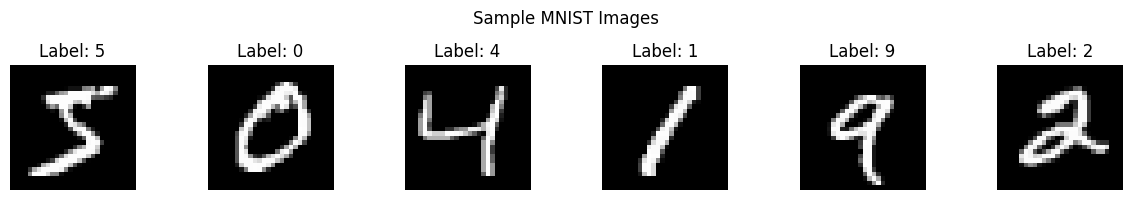

In [3]:
# Load the training data
mnist_raw = datasets.MNIST(root='.', train=True, download=True)

# Extract the image tensors and labels
images = mnist_raw.data
labels = mnist_raw.targets

# show the shape and data type
print(f"Image Tensor Shape: {images.shape}")
print(f"Data Type: {images.dtype}") # unit8 stands for "unsigned 8-bit integer", so it can represent numbers from 0 to 255
print(f"Label Shape: {labels.shape}")
print(f"Unique Labels: {labels.unique().tolist()}")

# print the first 6 images
fig, axs = plt.subplots(1, 6, figsize=(12, 2))
for i in range(6):
    axs[i].imshow(images[i], cmap='gray')
    axs[i].set_title(f"Label: {labels[i]}")
    axs[i].axis('off')
plt.suptitle("Sample MNIST Images")
plt.tight_layout()
plt.show()

## Analyze the mean/std of the Dataset

In [4]:
data = images.float() / 255.0 # convert to float and normalize to [0, 1]

# compute the mean and std
mnist_mean = data.mean().item() # .item() method in PyTorch is used to extract a single Python scalar from a PyTorch tensor
mnist_std = data.std().item() # that contains only one element

print(f"MNIST Mean: {mnist_mean:.4f}")
print(f"MNIST Std: {mnist_std:.4f}")

MNIST Mean: 0.1307
MNIST Std: 0.3081


## Reload and transform the Dataset

In [5]:
# Transform the data so that it has zero mean and unit variance, which helps models train faster and more stably
# We can transform the data automatically as it's being loaded

# first, define a transform operation

transform = transforms.Compose([    # combines together multiple transformation so that they can be applied in order to the data
    transforms.ToTensor(),    # first converts the image from an numpy array or image array to a PyTorch tensor
    transforms.Normalize((0.1307,), (0.3081,))  # then normalizes the tensor using the mean and STD of the dataset
])

train_dataset = datasets.MNIST(root='data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='data', train=False, transform=transform, download=True)

# prepare the dataset in mini-batches of size 64 and shuffle the data at each epoch
# Each mini-batch will be fed into the model and the loss is comput4ed for each mini-batch. The optimizer updates the weights
# after each mini-batch (standard SGD). At the end of the epoch, we typically aggregate the losses to evaluate the overall performance
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

## Defined the CNN Model with Dropout

In [6]:
class CNNWithDropout(nn.Module):

    def __init__(self):
        super(CNNWithDropout, self).__init__()

        # First convolutional layer: input 1x28x28 --> output 10x24x24
        # In PyTorch, the standard shape for image tensor is [Batch Size, Channels, Height, Width]
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=1, padding=0)

        # Second convolutional layer: input 10x12x12 (why?) --> output 20x8x8
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=1, padding=0)

        # Dropout layer after conv2
        self.dropout1 = nn.Dropout2d(p=0.25)

        # Fully connected layers
        self.fc1 = nn.Linear(320, 50) # flattend size: 20x4x4 = 320
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(50, 10) # 10 output class (digts 0-9)

    def forward(self, x):
        # Apply conv --> ReLU --> MaxPool
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.dropout1(self.conv2(x)), 2))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) # Log-Softmax for classification
        

## Training and Evaluation Functions

In [7]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target) # Negative Log Likelihood
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.4f}")

def test(model, device, test_loader):
    model.eval()
    correct = 0
    test_loss = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"\nTest set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n")

## Instantiate Model, Optimizer, and Run Training

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNWithDropout().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 6): # Train for 5 epochs
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000] Loss: 2.2720
Train Epoch: 1 [6400/60000] Loss: 0.5630
Train Epoch: 1 [12800/60000] Loss: 0.5167
Train Epoch: 1 [19200/60000] Loss: 0.3291
Train Epoch: 1 [25600/60000] Loss: 0.2988
Train Epoch: 1 [32000/60000] Loss: 0.1830
Train Epoch: 1 [38400/60000] Loss: 0.2188
Train Epoch: 1 [44800/60000] Loss: 0.2599
Train Epoch: 1 [51200/60000] Loss: 0.3853
Train Epoch: 1 [57600/60000] Loss: 0.1947

Test set: Avg. loss: 0.0813, Accuracy: 9747/10000 (97.47%)

Train Epoch: 2 [0/60000] Loss: 0.3089
Train Epoch: 2 [6400/60000] Loss: 0.1187
Train Epoch: 2 [12800/60000] Loss: 0.1146
Train Epoch: 2 [19200/60000] Loss: 0.1931
Train Epoch: 2 [25600/60000] Loss: 0.3192
Train Epoch: 2 [32000/60000] Loss: 0.1335
Train Epoch: 2 [38400/60000] Loss: 0.1513
Train Epoch: 2 [44800/60000] Loss: 0.1236
Train Epoch: 2 [51200/60000] Loss: 0.1898
Train Epoch: 2 [57600/60000] Loss: 0.0651

Test set: Avg. loss: 0.0499, Accuracy: 9840/10000 (98.40%)

Train Epoch: 3 [0/60000] Loss: 0.0974
Train Epoc

## Visualize the architecture of the neural network

### Use torchviz – For Graph Visualization

- It draws the computation graph, great for understanding layer connections and flow.
- generates a real graph (saved as PNG, PDF, etc.)


In [11]:
from torchviz import make_dot

import torch
model = CNNWithDropout()
dummy_input = torch.randn(1, 1, 28, 28)
output = model(dummy_input)

make_dot(output, params=dict(model.named_parameters())).render("cnn_graph", format="png")

'cnn_graph.png'

### Use torchsummary to Quick and Easy Overview

- Gives a compact, layer-by-layer summary
- Input/output shapes, parameter counts, total memory usage
- Use it when you want a quick idea of the model’s structure without visualizing it.

In [13]:
from torchsummary import summary

model = CNNWithDropout()
summary(model, input_size=(1, 28, 28)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]           5,020
         Dropout2d-3             [-1, 20, 8, 8]               0
            Linear-4                   [-1, 50]          16,050
           Dropout-5                   [-1, 50]               0
            Linear-6                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.08
Estimated Total Size (MB): 0.15
----------------------------------------------------------------
